## Create the environment, the buffer and the VAE

Create environment.

In [1]:
import gym

env = gym.make("PrivateEye-v4")

/home/qgallouedec/go-explore/env/lib/python3.8/site-packages/gym/envs/registration.py:505: UserWarning: WARN: The environment PrivateEye-v4 is out of date. You should consider upgrading to version `v5` with the environment ID `ALE/PrivateEye-v5`.
  logger.warn(
A.L.E: Arcade Learning Environment (version 0.7.5+db37282)
[Powered by Stella]


Choose the device.

In [2]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

Create a buffer and feed it.

In [3]:
import numpy as np

from stable_baselines3.common.buffers import ReplayBuffer


buffer = ReplayBuffer(10000, env.observation_space, env.action_space, device=device)

for episode in range(10):
    done = False
    obs = env.reset()
    while not done:
        action = np.array(env.action_space.sample())
        next_obs, reward, done, info = env.step(action)
        buffer.add(obs, next_obs, action, reward, done, [info])
        obs = next_obs

Create a categorical VAE.

In [4]:
from go_explore.vae import CNNCategoricalVAE

vae = CNNCategoricalVAE().to(device)

/home/qgallouedec/go-explore/env/lib/python3.8/site-packages/torchvision/transforms/functional_pil.py:228: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  interpolation: int = Image.BILINEAR,
/home/qgallouedec/go-explore/env/lib/python3.8/site-packages/torchvision/transforms/functional_pil.py:295: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  interpolation: int = Image.NEAREST,
/home/qgallouedec/go-explore/env/lib/python3.8/site-packages/torchvision/transforms/functional_pil.py:328: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  interpolation: int = Image.BICUBIC,


## Test the VAE

Sample a batch of observations.

In [5]:
input = buffer.sample(10).observations

Transpose and resize.

In [6]:
from torchvision.transforms.functional import resize

input = input.moveaxis(-1, -3)
input = resize(input, (129, 129)).float() / 255

Build the reconstruction.

In [7]:
recons, kl_loss = vae(input)

Visualize the result.

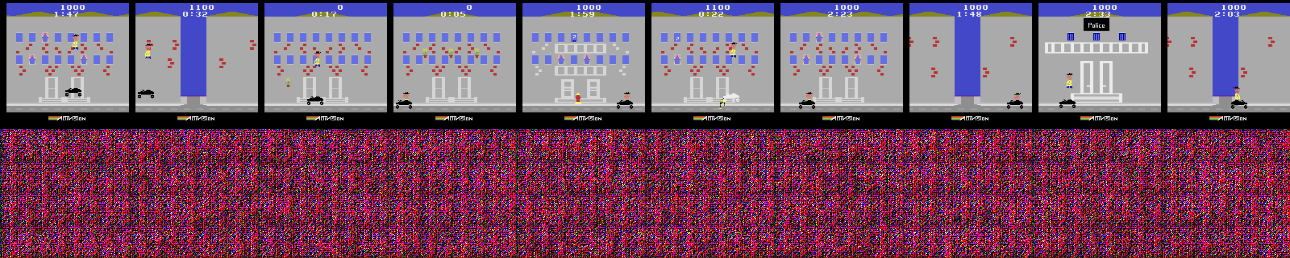

In [8]:
from go_explore.utils import build_image

build_image([input, recons])

## Train the model

Create the loss function.

In [9]:
import torch.nn.functional as F
from typing import Tuple


def loss_func(
    input: torch.Tensor, recons: torch.Tensor, kl_loss: torch.Tensor
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    # Reconstruction loss
    recons_loss = F.mse_loss(input, recons)

    # Total loss
    loss = recons_loss + 0.01 * kl_loss
    return loss, recons_loss

Test the loss function.

In [10]:
loss_func(input, recons, kl_loss)

(tensor(0.6790, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.6790, device='cuda:0', grad_fn=<MseLossBackward0>))

Create optimizer.

In [11]:
from torch import optim

optimizer = optim.Adam(vae.parameters(), lr=2e-4)

In [12]:
# Used for visualisation at the end
test_image = buffer.sample(5).observations
test_image = test_image.moveaxis(-1, -3)
test_image = resize(test_image, (129, 129)).float() / 255
images = [test_image]

for epoch in range(5000):
    # Sample
    input = buffer.sample(32).observations
    input = input.moveaxis(-1, -3)
    input = resize(input, (129, 129)).float() / 255

    # Compute the output image
    vae.train()
    recons, kl_loss = vae(input)

    # Compute the loss
    loss, recons_loss = loss_func(input, recons, kl_loss)

    # Step the optimizer
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(
            "epoch: {:5d}\tloss: {:.5f}\trecons loss: {:.5f}\tkl loss: {:.5f}".format(
                epoch, loss.item(), recons_loss.item(), kl_loss.item()
            ),
        )
        vae.eval()
        images.append(vae(test_image)[0])

epoch:     0	loss: 0.68658	recons loss: 0.68655	kl loss: 0.00234
epoch:  1000	loss: 0.01029	recons loss: 0.00940	kl loss: 0.08957
epoch:  2000	loss: 0.00614	recons loss: 0.00527	kl loss: 0.08705
epoch:  3000	loss: 0.00482	recons loss: 0.00400	kl loss: 0.08239
epoch:  4000	loss: 0.00417	recons loss: 0.00334	kl loss: 0.08302


Visualize the result. First row is a batch of image from the buffer, and each following row is the reconstruction during the training.

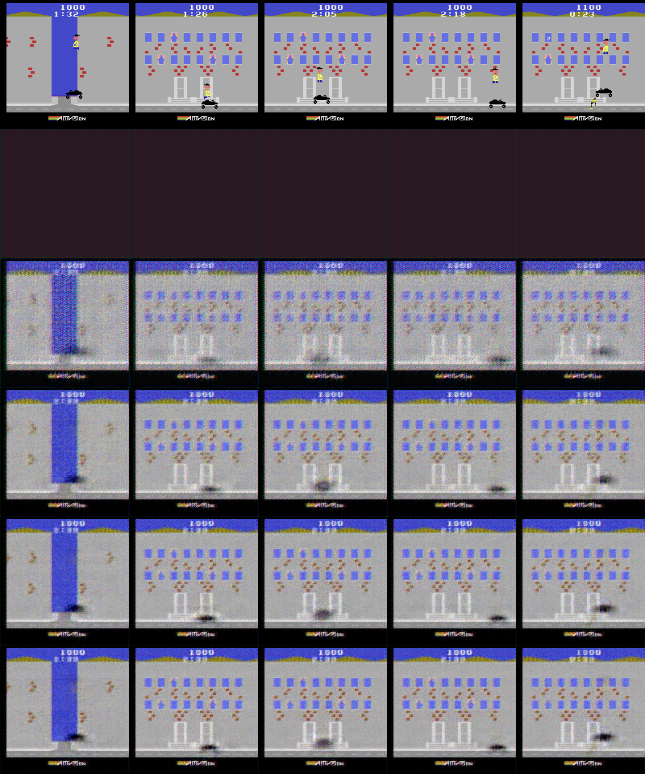

In [13]:
build_image(images)